# Lecture 5. Linear Regression, CV, Ridge and Lasso
--- 

### CS 109A/AC 209A/STAT 121A Data Science:
### Harvard University
Fall 2016 <br>
Instructors:  P. Protopapas, K. Rader, W. Pan




--- 

# Announcements 
 
- Grades are to 5 (with bonus 5.5) 
- Quiz policies:
    - Open books (you you only have 5 minutes/15 for DCE students once you open it.)
    - Do not share the secret code  
- Wednesday: Continue on linear regression  

- All lectures notes are now clean, corrected and no more spelin misaces 
    
---


In [64]:
# Quiz
import sys
import time

def countdown(n):
    #print("QUIZ TIME")
    for i in range(1*n,0,-1):
        time.sleep(1)
        sys.stdout.write(str(i)+' ')
        sys.stdout.flush()

--- 
# QUIZ TIME
{{countdown(100)}}
---

----

# Outline 
- Review and where we are heading
- Cross Validation
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso 


   

---  


----

# Outline 
- ** Review and where we are heading ** 
- Cross Validation
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso 


   

---  


In [65]:
#IMPORTS 
from IPython.display import Image
from ipywidgets import interact,  FloatSlider, RadioButtons
import numpy as np 
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg

import itertools as it
import statsmodels.api as sm
import pandas as pd

In [66]:
# FONTS ETC 
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

---
## Review: The story so far 

- Start with data: (X,Y)
    - $n$ observations and $p$ predictors $X_{n\times p}$. $Y$ has $n$ observations.

- Fit the model using ordinary least square (OLS) as the lost function $L(\beta)= \sum_{i}^{n} (y_i - \beta_0 - \sum_j^p \beta_j x_{ij})^2 $ 
    - Estimate $\beta$'s that minimize the OLS $\rightarrow \hat{\beta}$. 
    This applies to single, multi and polynomial 
    - Predict $Y$'s as:  $\hat{Y} = \hat{\beta}_0+\sum_j^p \hat{\beta_j} x_{ij} $ 


- Model assessment:
    - RSS or MSE or $R^2$ 
    - Does the response depend on the predictors? 
        - Check standard errors SE 
        - Check confidence intervals 
        - Do hypothesis testing: t-test, p-value and F-test for multivariate 
        

    
- Model Selection
    - Multiple predictors:
        - Exhaustive (too expensive) 
        - Forward stepping 
        - Backward stepping 
    - Polynomial: 
        - Use Adjusted $R^2$, AIC, BIC because more flexible models will result in larger $R^2$ but over-fit

Often for model assessment and model selection we use cross-validation approach (test/training) 

--- 


---
### What's next
Today's materials. For Wednesday
- Binary predictors 
- Interaction terms
- Something on collinearity
- Probabilistic view of linear regression: Likelihood -> AIC/BIC 
- Where OLS, ridge and lasso fail

After we move to dimensionality reduction and eventually Logistic Regression

---

----

# Outline 
-  Review and where we are heading  
- ** Cross Validation ** 
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


---
## Cross Validation

Resampling is a procedure in which we repeatedly draw samples from a set of observations, and we refit a model on each sample. Resampling is used to ** estimate the variability of the model fit **  and to ** determine the error rate of the model ** when applied to new previously unseen data.
This mimics the approach of out of sample prediction. 
Resampling can also help in ** selecting the flexibility of a model**.

There are many resampling techniques available. Some of the most popular ones include  Validation Set, Cross-Validation techniques (K-Fold, Leave-One-Out, etc.), Bootstrap.
    

    
All these methods rely on splitting the data in some way to Test/Train either by simply splitting them or resample from the entire dataset (bootstrap). 

The good and the bad: 
 - Good: Test error can be easily calculated for a test set if the test set is available to us
 - Bad: Unfortunately, many cases we do NOT have a test set
 - Good: The train error may be misleading [see figure below from the example from the last lecture] so these methods provide a way to estimate the real predictive errors
 

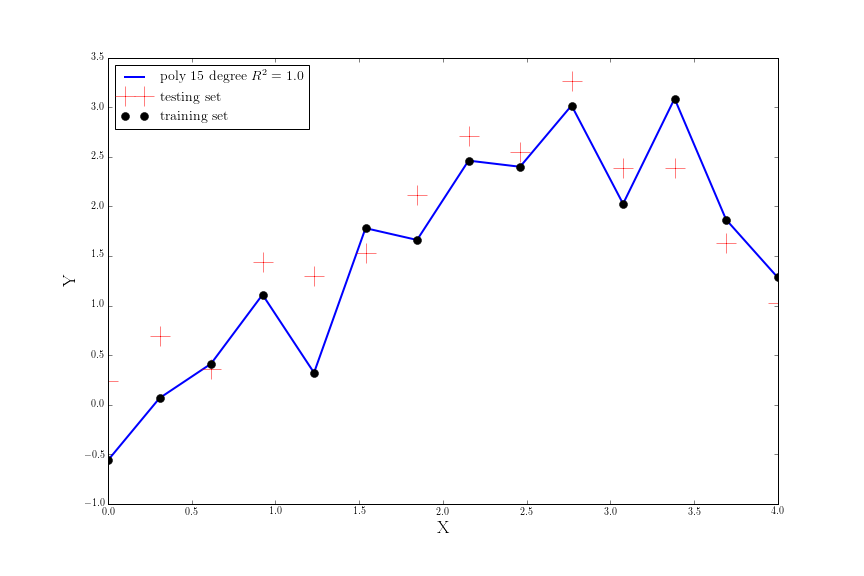

In [67]:

Image(filename='train_test.png') 

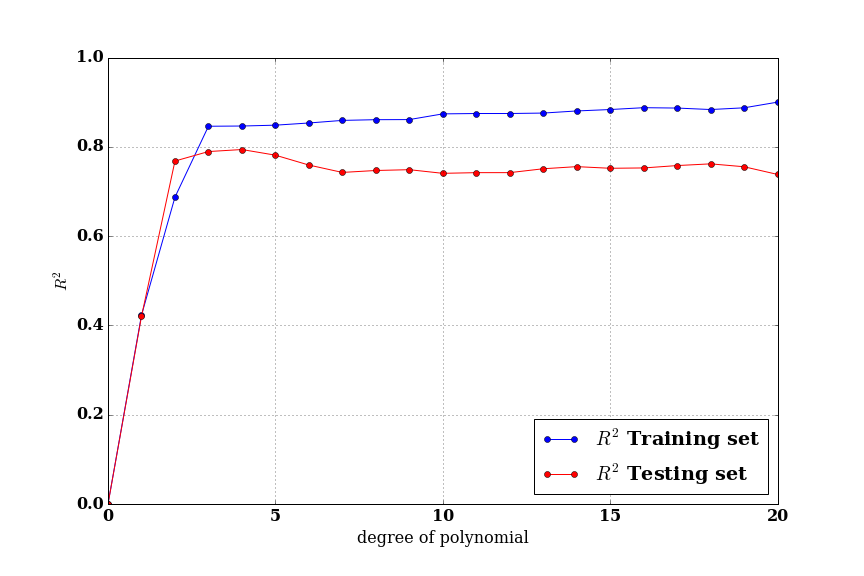

In [68]:
Image(filename='CrossValidation_poly.png') 

In [69]:
 

def polynomial_regression_fit(x, y, degrees):
    # Create the poly terms for x,x^2 .. 
    
    n= np.size(y)   # data size 
    x_poly = np.zeros([n, degrees]) # poly degree 
    
    
    for d in range(1, degrees +1):
        x_poly[:, d - 1] = np.power(x, d).flatten()  # adding terms 

    Xt=sm.add_constant(x_poly)
    model=sm.OLS(y,Xt)
    model_results=model.fit()
    return model_results, Xt


def polynomial_regression_predict(params, degrees, x):
    # # Create the poly terms for x,x^2 ..
    n = x.shape[0]
    x_poly = np.zeros([n, degrees])
    for d in range(1, degrees + 1):
        x_poly[:, d - 1] = np.power(x, d).flatten()
        
    Xt=sm.add_constant(x_poly)
    Xt=sm.add_constant(x_poly)
   
    # Predict y-vals
    y_pred = np.dot(params,Xt.T)
        
    return y_pred


---
## Validation Set Approach

- Randomly divide the data into two parts the training and validation.
- Fit the model on the training set and the fitted model is used to predict the response for the testing points. MSE (or $R^2$) is used a validation error. 

<img src="http://rnfc.org/ivey/introduction-to-data-science/Lesson%205/Summary/Figures/Figure5-1.png">

- Discuss multiple renditions of splitting the data

- Discuss drawbacks 
  - Variability in the estimation of $R^2$ on test
  - Loosing data for fitting thus test error is exaggerated (see the extreme case of one observation is used to fit) 
  
  
---

---
## Validation Set Approach. The Auto data set





In [70]:
data = pd.read_csv('Auto.csv', sep=',')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [71]:
mpg=data['mpg'].values
horsepower=data['horsepower'].values

for k,h in enumerate(horsepower):
    x=type(float(h))
    
dt= np.vstack( [horsepower, mpg]).T

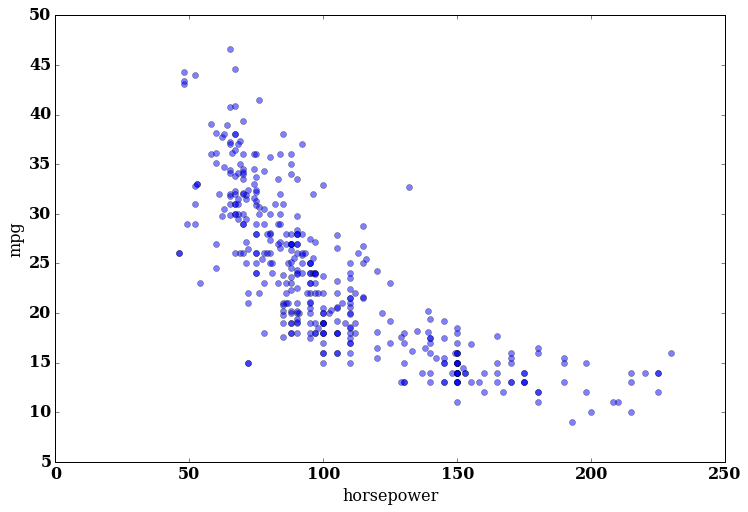

In [72]:
plt.figure(figsize=(12,8))
plt.plot(horsepower, mpg,  'bo', alpha=0.5)
horsepower.shape
plt.xlabel('horsepower'); plt.ylabel('mpg')

In [90]:
# FIT POLYNOMIALS 

N=mpg.shape[0]

degress = 15
nsim=10


R2_test = np.zeros([ degrees+1,nsim])
R2_train = np.zeros([ degrees+1,nsim])
MSE_train = np.zeros([ degrees+1,nsim])
MSE_test = np.zeros([ degrees+1,nsim])



In [91]:
degrees=12
for i in np.arange(0,nsim):
    data_train=np.random.permutation(dt)[0:N/2]
    data_test=np.random.permutation(dt)[N/2:]

    X_train = data_train[:, 0:-1]
    Y_train = data_train[:, -1]

    X_test = data_test[:, 0:-1]
    Y_test = data_test[:,-1]

    

    for d in range(1, degrees +1):
        model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
        R2_train[d, i] = model_results.rsquared
      
        yp=polynomial_regression_predict(model_results.params, d, X_train)
        RSS_train=np.sum((Y_train-yp)**2)

        MSE_train[d,i]=RSS_train/(N/2-degrees)
        

        y_hat=polynomial_regression_predict(model_results.params, d, X_test)
        RSS_test = np.sum((Y_test-y_hat)**2)
        TSS_test = np.sum((Y_test-np.mean(Y_test))**2)
        MSE_test[d,i]=RSS_test/(N/2-degrees)
        R2_test[d,i] = 1.0-RSS_test/TSS_test

MSE_train_mean = np.zeros([degrees+1,1])  
MSE_test_mean = np.zeros([degrees+1,1])  
MSE_test_std = np.zeros([degrees+1,1])  
MSE_train_std = np.zeros([degrees+1,1])  
dlist=np.zeros([degrees+1,1])  

for d in range(1, degrees +1):
        MSE_train_mean[d]= MSE_train[d,:].mean()
        MSE_test_mean[d]= MSE_test[d,:].mean()
        MSE_train_std[d] = MSE_train[d,:].std()
        MSE_test_std[d] = MSE_test[d,:].std()
        dlist[d] = d
        
        

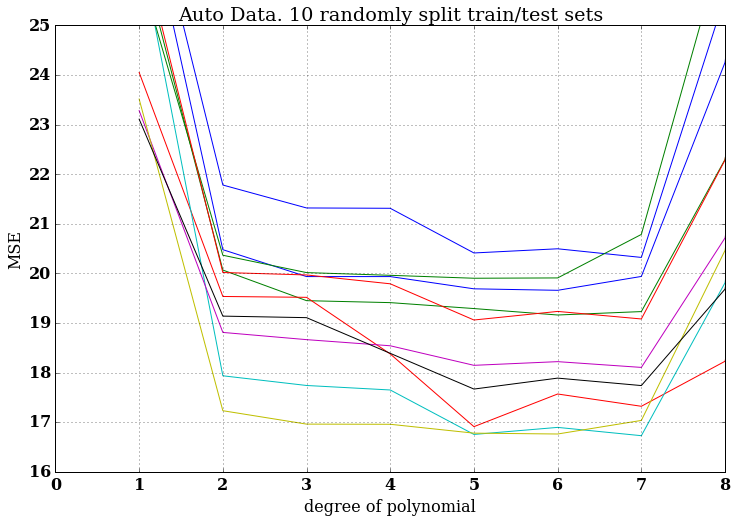

In [93]:


plt.figure(figsize=(12,8))
plt.plot(dlist[1:], MSE_train[1:,:])
plt.ylim((16,25)); plt.xlim((0,8))
plt.xlabel('degree of polynomial'); plt.ylabel(r'MSE')
plt.xlabel('degree of polynomial'); plt.grid(); plt.title('Auto Data. 10 randomly split train/test sets')
plt.savefig('AutoVS.png')

In [77]:

N =100
sigma =.4 
epsilon=np.random.normal(0,sigma,N)
Xmin=0
Xmax=4
X = np.linspace(Xmin,Xmax, N) 
Y = 0.2+.2*X + 0.8*X**2 - 0.2 *X**3+ epsilon

data= np.vstack( [X,Y]).T


In [78]:
# 

degress=15
nsim=400

R2_test = np.zeros([ degrees+1,nsim])
R2_train = np.zeros([ degrees+1,nsim])
MSE_train = np.zeros([ degrees+1,nsim])
MSE_test = np.zeros([ degrees+1,nsim])


for i in np.arange(0,nsim):
    data_train=np.random.permutation(data)[0:N/2]
    data_test=np.random.permutation(data)[N/2:]

    X_train = data_train[:, 0:-1]
    Y_train = data_train[:, -1]

    X_test = data_test[:, 0:-1]
    Y_test = data_test[:,-1]


    

    for d in range(1, degrees +1):
        model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
        R2_train[d, i] = model_results.rsquared
      
        yp=polynomial_regression_predict(model_results.params, d, X_train)
        RSS_train=np.sum((Y_train-yp)**2)

        MSE_train[d,i]=RSS_train/(N/2-degrees)
        

        y_hat=polynomial_regression_predict(model_results.params, d, X_test)
        RSS_test = np.sum((Y_test-y_hat)**2)
        TSS_test = np.sum((Y_test-np.mean(Y_test))**2)
        MSE_test[d,i]=RSS_test/(N/2-degrees)
        R2_test[d,i] = 1.0-RSS_test/TSS_test

MSE_train_mean = np.zeros([degrees+1,1])  
MSE_test_mean = np.zeros([degrees+1,1])  
MSE_test_std = np.zeros([degrees+1,1])  
MSE_train_std = np.zeros([degrees+1,1])  
dlist=np.zeros([degrees+1,1])  

for d in range(1, degrees +1):
        MSE_train_mean[d]= MSE_train[d,:].mean()
        MSE_test_mean[d]= MSE_test[d,:].mean()
        MSE_train_std[d] = MSE_train[d,:].std()
        MSE_test_std[d] = MSE_test[d,:].std()
        dlist[d] = d

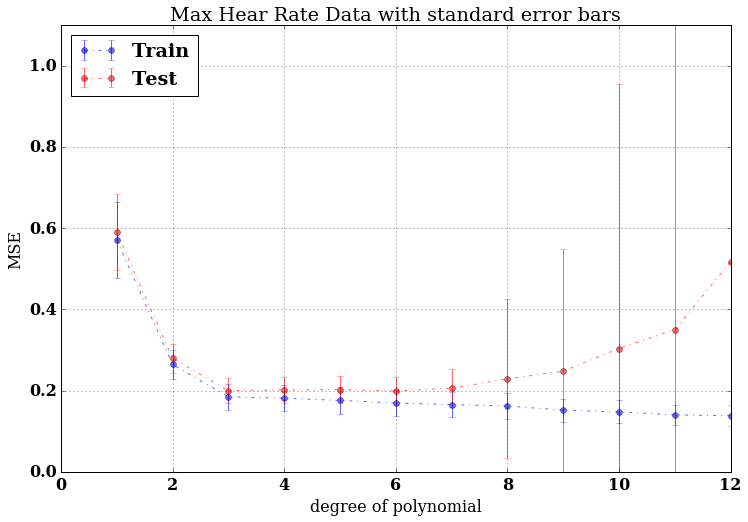

In [79]:

plt.figure(figsize=(12,8))
h1=plt.errorbar(dlist[1:],MSE_train_mean[1:], yerr=MSE_train_std[1:],  fmt='b-.o', alpha=0.6, label='Train')
h2=plt.errorbar(dlist[1:],MSE_test_mean[1:], yerr=MSE_test_std[1:], fmt='r-.o',alpha=0.6, label='Test')

plt.ylim((0,1.1)); plt.xlim((0,12))
plt.xlabel('degree of polynomial'); plt.ylabel(r'MSE')
plt.xlabel('degree of polynomial'); 
plt.legend(loc='best', handles =[h1, h2])
plt.title('Max Hear Rate Data with standard error bars')
plt.grid()

---
## Validation Set Approach (cont)

- Validation estimate of the test error rate can be highly variable. That depends on which observations are included in the training set and which observations are included in the validation set.
- In the validation approach, we only use a subset of the observations to fit the model
    $\rightarrow$ Overestimate the test error rate compared to a fit of the whole dataset
    
---- 


----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - ** Leave one out **
    - k-Fold cross validation
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


--- 
## Cross Validation: Leave one out cross validation 

- Like the validation set but use n-1 to fit and test on 1 (sub-slide) 

<img src="Images/Slide3.png" alt="" style="width:604px;">

<img src="Images/Slide4.png" alt="" style="width:604px;">

--- 
- Say we leave the i-th point out,  the validation error is
$$ {\rm MSE}_k = (\hat{y}_k - y_k)^2$$


- Average the errors from all $n$ times
$$ CV_n = \frac{1}{n} \sum_i {\rm MSE}_i $$


LOOCV is more accurate than using validation set, since we are using $n-1$ data points as oppose to some fraction of n (n/2).
- No randomness, always the same results 
- Could be computationally demanding since we need to fit the model $n$ times, but there is a magic trick

$$ CV_n = \frac{1}{n} \sum_i \left(\frac{y_i-\hat{y}_i}{1-h_i}\right)^2 $$

where $h_i$ is the leverage defined as:

$$ h_i = \frac{1}{n}+ \frac{(x_i-\bar{x})^2}{\sum_j (x_j-\bar{x})^2} $$ 

---- 
Note: General method to be used with other methods such as logistic regression 

In [87]:
## Now do cross validation k=1-fold
def AutoLOO(dt):
    K= dt.shape[0]
    step = 1
    nsim = 1
    degrees= 10

    plt.figure(figsize=(12,8))

    MSE_train = np.zeros([ degrees+1,K])
    MSE_test = np.zeros([ degrees+1,K])
    MSE_K = np.zeros([ degrees+1,nsim])



    for j in np.arange(0,nsim):
        #dt=np.random.permutation(dt)[0:N]

        for i in np.arange(0,K):

            data_train = np.concatenate( (dt[:i*step] , dt[(i+1)*step:-1]))
            data_test = dt[i*step:(i+1)*step]


            X_train = data_train[:, 0:-1]
            Y_train = data_train[:, -1]

            X_test = data_test[:, 0:-1]
            Y_test = data_test[:,-1]




            for d in range(2, degrees +1):
                model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
                yp=polynomial_regression_predict(model_results.params, d, X_train)
                RSS_train=np.sum((Y_train-yp)**2)

                MSE_train[d,i]=RSS_train/(N/2.0-degrees)


                nn = X_test.shape[0]
                x_poly = np.zeros([nn, d])
                for d in range(1, d + 1):
                    x_poly[:, d - 1] = np.power(X_test, d).flatten()
                #print 'x_poly:',x_poly

                uno= np.ones( (1,1))
                Xt=np.hstack( (uno, x_poly))



                # Predict y-vals
                y_hat = np.dot(model_results.params,Xt.T)

                #y_hat=polynomial_regression_predict(model_results.params, d, X_test)
                RSS_test = np.sum((Y_test-y_hat)**2)
                MSE_test[d,i]=RSS_test/(N/2.0-degrees)
                


        for d in range(1, degrees +1):
            MSE_K[d,j] = MSE_test[d,i].mean()

        dlist=np.linspace(1, MSE_K.shape[0],MSE_K.shape[0]-1 )
        print dlist.shape, MSE_K[1:, j].shape
        plt.plot(dlist,MSE_K[1:, j], 'b-o')
        plt.xlabel('degree of polynomial');plt.title('Auto Data LOO') 
        plt.ylabel('MSE')
    

(10,) (10,)


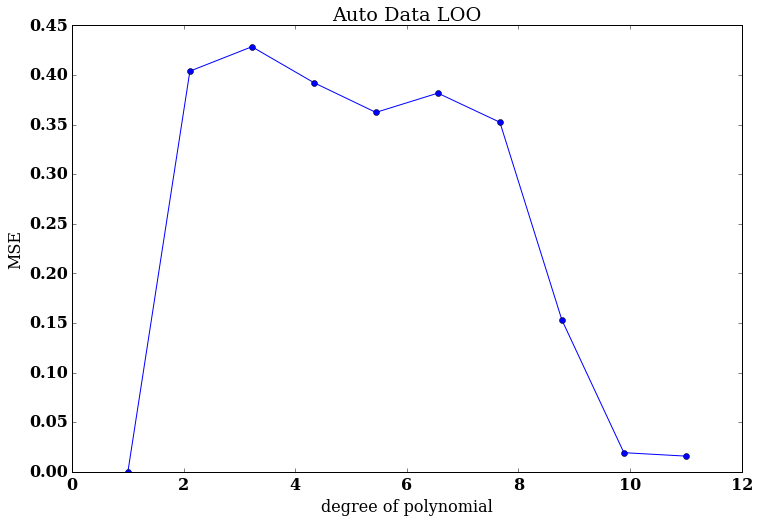

In [86]:
AutoLOO(dt)

----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - Leave one out 
    - ** k-Fold cross validation **
    - Bootstrapping 
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  


--- 
## Cross Validation: k-Fold

- Split data into folds. Use one for validation the rest for training and repeat k times
- Computationally efficient 





<img src="k_FOLD/Slide1.jpg" alt="" style="width:604px;">


<img src="k_FOLD/Slide2.jpg" alt="" style="width:604px;">


### k-Fold CV (cont) 

Comparing the Auto dataset 

In [102]:
## Now do cross validation k-fold
def AutoKfold(dt, K):
    step = N/K 
    nsim = 9
    degrees= 10

    plt.figure(figsize=(12,8))

    MSE_train = np.zeros([ degrees+1,K])
    MSE_test = np.zeros([ degrees+1,K])
    MSE_K = np.zeros([ degrees+1,nsim])



    for j in np.arange(0,nsim):
        dt=np.random.permutation(dt)[0:N]

        for i in np.arange(0,K):
            data_train = np.concatenate( (dt[:i*step] , dt[(i+1)*step:-1]))
            data_test = dt[i*step:(i+1)*step]


            X_train = data_train[:, 0:-1]
            Y_train = data_train[:, -1]

            X_test = data_test[:, 0:-1]
            Y_test = data_test[:,-1]

            for d in range(1, degrees +1):
                model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
                yp=polynomial_regression_predict(model_results.params, d, X_train)
                RSS_train=np.sum((Y_train-yp)**2)
                MSE_train[d,i]=RSS_train/(N/2-degrees)



                y_hat=polynomial_regression_predict(model_results.params, d, X_test)
                RSS_test = np.sum((Y_test-y_hat)**2)
                TSS_test = np.sum((Y_test-np.mean(Y_test))**2)
                MSE_test[d,i]=RSS_test/(N/2-degrees)
                


        for d in range(1, degrees +1):
            MSE_K[d,j] = MSE_test[d,i].mean()

        plt.title('Auto Data k-Fold'); plt.xlabel('Polynomial degree'); plt.ylabel('MSE')
        plt.plot(MSE_K[1:, j]); plt.grid()
        plt.ylim((3,25))


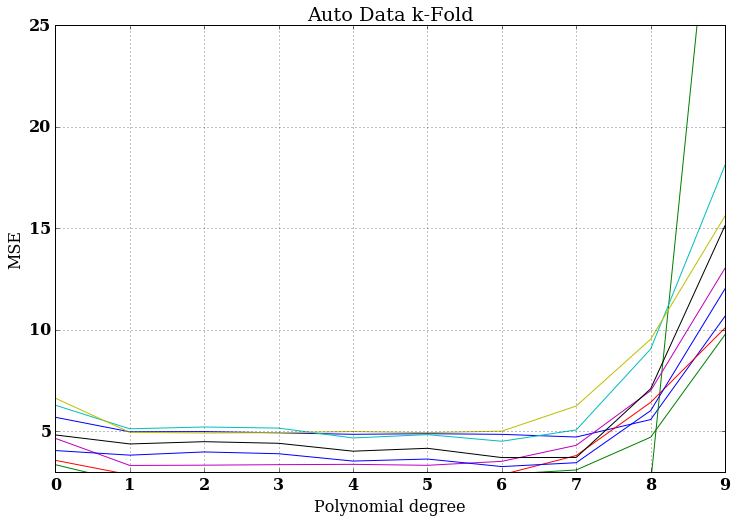

In [103]:
AutoKfold(dt, 10)


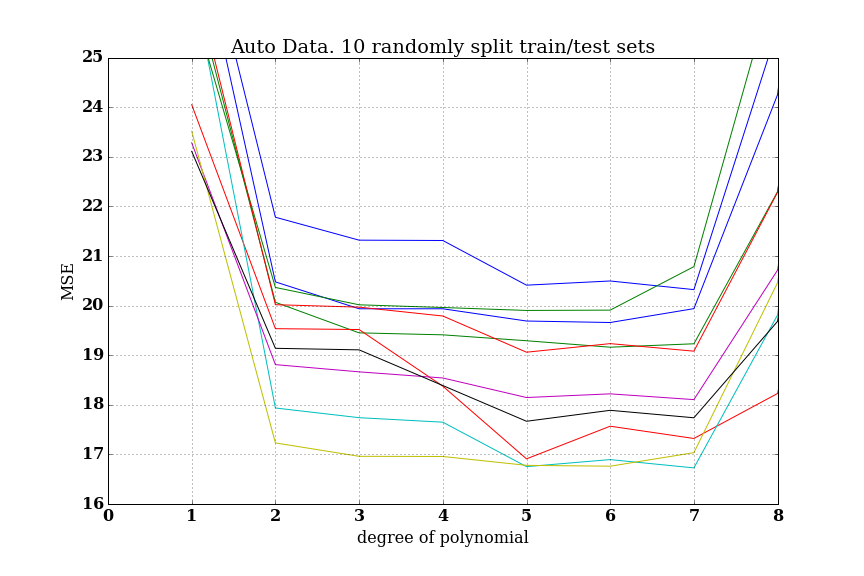

In [104]:
Image('AutoVS.png')

### K-Fold vs LOO
 

LOOCV has  higher variance than does k-fold CV. This is because LOOCV, in effect is averaging the outputs of n fitted models, each of which is trained on an almost identical set of observations.

<img src="LOOKFold_comparison.png">

--

LOOCV is black, 10-fold is orange, true in blue. Three synthetic data sets. 

----

# Outline 
-  Review and where we are heading  
- Cross Validation 
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - ** Bootstrapping **
- Shrinkage Methods
    - Ridge Regression 
    - Lasso  

---  



## Bootstrap 

- A very simple 

widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method





<img src="Images/Slide5.png" alt="" style="width:604px;">

<img src="Images/Slide7.png" alt="" style="width:604px;">


In [56]:
def plotSE():

    # Load train set
    data = pd.read_csv("maxheartrate.csv") 

    x = data['age'].values
    y = data['maxheartrate'].values

 
    # Size of the data set
    n = x.shape[0]


    # No. of subsamples
    num_samples = 200

    ### Linear regression 

    # Create a n  array to store coefficients for all subsamples
    coefs_a = np.zeros((num_samples, 2))


    for i in range(num_samples):

        # Generate a random subsample of data points
        # This is the bootstrap 
        # 
        perm =np.random.randint(low=0, high=n, size=n) # Generate a list of indices 0 to n and permute it
        x_subsample = x[perm] 
        y_subsample = y[perm] 

        # Fit linear regression model on subsample
        #
        xt= sm.add_constant(x_subsample)
        model = sm.OLS( y_subsample, xt)
        model_results= model.fit()

        # Store the coefficient for the model we obtain
        coefs_a[i, :] = model_results.params


    # Plot histogram of coefficients, and report their confidence intervals 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    
    # HOW DOES IT COMPARED TO STANDARD CONF INTERVAL WITHOUT BOOTSTRAP ?
    xt = sm.add_constant(x)
    model=sm.OLS(y,xt)
    model_res=model.fit()
    print "Theoretical estimate: SE beta_0", np.sqrt(model_results.mse_resid*(1.0/n+ x.mean()**2/np.sum( (x-x.mean())**2)))
    print "Theoretical estimate: SE beta_1", np.sqrt(model_results.mse_resid/np.sum( (x-x.mean())**2))
    
    # Repeat for each coefficient (this is just the confidence intervals )
    for j in range(2):
        # Compute mean for the j-th coefficent from subsamples
        coef_j_mean = np.mean(coefs_a[:, j])

        # Compute confidence interval at 95% confidence level (use formula!)
        conf_int_left = np.percentile(coefs_a[:, j], 2.5)
        conf_int_right = np.percentile(coefs_a[:, j], 97.5)
        print('Bootstrap: SE'+ r' beta_'+str(j) +' =', np.mean(coef_j_mean.mean()-conf_int_left) /2) 
       
        # Plot histogram of coefficient values
        axes[j].hist(coefs_a[:, j], alpha=0.5)

        # Plot vertical lines at mean and left, right extremes of confidence interval
        axes[j].axvline(x = coef_j_mean, linewidth=3)
        axes[j].axvline(x = conf_int_left, linewidth=1, c='r')
        axes[j].axvline(x = conf_int_right, linewidth=1, c='r')

        # Set plot labels
        axes[j].set_title('[' + str(round(conf_int_left, 4)) 
                          + ', ' 
                          + str(round(conf_int_right, 4)) + ']')
        axes[j].set_xlabel('Predictor ' + str(j + 1))
        axes[j].set_ylabel('Frequency')

    plt.show()
    
    

Theoretical estimate: SE beta_0 0.534878446555
Theoretical estimate: SE beta_1 0.00971112555127
('Bootstrap: SE beta_0 =', 0.54535102055086782)
('Bootstrap: SE beta_1 =', 0.0090006101950404482)


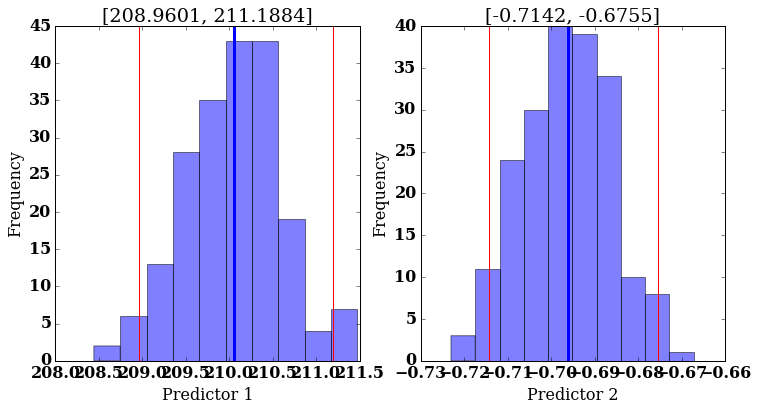

In [105]:
plotSE()

----

# Outline 
-  Review and where we are heading  
- Cross Validation  
    - Validation Set
    - Leave one out 
    - k-Fold cross validation
    - Bootstrapping 
- ** Shrinkage Methods ** 
    - Ridge Regression 
    - Lasso  

---  


--- 
## Shrinkage Methods
- So far we discussed the subset selection methods, and we also saw polynomial regression. All so far used least squares to fit a linear model that contains a subset of the predictors.
   

- Alternatively, we can fit a model containing all $p$ predictors using a technique that shrinks the coefficient estimates towards zero.
   
- Not obvious but somehow magically doing this improves the error of the fit
  
  
- Two well known methods for shrinking the coefficients towards zero are ridge regression and the lasso. 

---

In ordinary least square  regression, we minimize RSS 

$$ RSS = \sum_{i=1}^{n}\left(y_i  - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 $$


In the ridge regression, the coefficients are estimated by minimizing a slightly different quantity. In particular, the ridge regression coefficient estimates $\hat{\beta}^{R}$ are the values that minimize

$$ \sum_{i=1}^{n}\left(y_i  - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2  + \lambda \sum_{j=1}^{p} \beta_k^2 = RSS + \lambda \sum_{j=1}^{p} \beta_k^2 $$

where $\lambda$ must be larger than zero and it is a tuning parameter. $\lambda$ has to be determined as well during the fitting procedure. 

 The tuning parameter $\lambda$ serves to control the relative impact of these two terms on the regression coefficient estimates.
 
 When $\lambda=0$ the extra term has no effect so we go back to OLS and when $\lambda$ is very large all coefficients approach zero. 
 

 Unlike the least squares regression here we find a set of $\beta$'s for every value of $\lambda$. 
 
 NOTE: We do not shrink $\beta_0$ 
 
 NOTE: The shrinkage is related to priors in a Bayesian formalism. We will come to this later in the semester 

-----
### Ridge - scaling 
Because the ridge regression equation has that extra term, if a predictor is multiplied by a constant (change units) the resulting regression coefficients change. 
Because of that before we apply ridge regression we  standardize the predictors as:

$$ \tilde{x}_{ij} = \frac{x_{ij}}{ \sqrt{\frac{1}{n} \sum_i^n (x_{ij}-\bar{x}_j)^2}} $$


so all predictors are on the same scale and have standard deviation of 1. 

----

---
### Ridge - Computational complexity 

The solution of the ridge regression involves two steps. 
- Select $\lambda$ 
- Find the minimum using linear algebra as with the multiple regression 

---- 
Note: Smart techniques have been proposed how to walk from $\lambda$ to new $\lambda$ (not in the scope of this course)

---

### Ridge Regression - Why does it work?

First we need to formalize test error 

Test error = bias + variance + irreducible error 

Why does the regularization reduce variance though increases the bias?  

Imagine the scenario that we have the correct polynomial, say cubic and we fit a cubic polynomial and consider the case we have few points.  A small variation in the training set will result in a large change of the OLS coefficients since there will be many combinations to get to the training points. However, ridge regression has to keep those coefficients smaller thus restrict the possibility of overfitting and therefore reduces the variance. Of course, the bias will increase. For some value of $\lambda$ we can get the best of both worlds. 



<img src = http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png/>

---

<img src = "RidgeVarianceBias.png">

--- 
A. Simulated data. Black is the bias, green is variance, purple the test MSE

--- 

### Ridge - Example - Credit 

The way we do this is via cross-validation (k-Fold) 
HOW? 
1- Data -> train 
2- Bootstrap-> calculate MSE on test data

In [60]:
data = pd.read_csv('Credit.csv', sep=',')
data.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


<img src="Ridge.png"/>

---- 
Credit data

Not easy to proof but it is possible to show that the expected test MSE, for a given test point  can be expressed as 

$\mathrm{MSE}(x) = \mathbb{E}(f(x) - \hat{f}(x)) = \mathrm{bias}_x^2 + \mathrm{variance}_x + \sigma^2$, 

where

$\mathrm{bias}_x = \mathbb{E}(\hat{f}(x))- f(x)$

$\mathrm{variance}_x = \mathrm{Var}(\hat{f}(x)) = \mathbb{E}[\left(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\right)^2]$

$\sigma$ = standard deviation of the noise.

notation E y0 − f(x0) defines the expected test MSE, and refers
to the average test MSE that we would obtain if we repeatedly estimated
f using a large number of training sets, and tested each at x0. The overall
􏰊 ˆ 􏰋2 expected test MSE can be computed by averaging E y0 − f(x0) over all
possible values of x0 in the test set.


How do proof that. We synthesize training sets, we estimate $f(x_0)$ etc 

---
## The LASSO 

Ridge regression has a disadvantage. It does not select a subset of predictors unlike best subset, forward stepwise, and backward stepwise selection. It will shrink the coefficients but it will not reduce them to zero unless $\lambda \rightarrow \infty$ 

Even though it is not a problem for model accuracy, it is harder to interpret the model, especially when the number of predictors is large. 

Lasso is an alternative to ridge that overcomes this disadvantage


$$ \sum_{i=1}^{n}\left(y_i  - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2  + \lambda \sum_{j=1}^{p} |\beta_k| = RSS + \lambda \sum_{j=1}^{p} |\beta_k| $$


Ridge and lasso are very similar, both trying to constrain the coefficients with an extra term.
Ridge is l2 where lasso is l1 




---



# Lasso (cont)

- Lasso also shrinks the coefficient estimates towards zero. 
- The l1 penalty forces  some of the coefficients  to be **exactly** equal to zero 
- The tuning parameter λ has to be estimated as with ridge with cross-validation.
- Lasso  performs variable selection and therefore easier to interpret (sparse models) 

<img src="Lasso.png" alt="" style="width:804px;">

## Lasso and Ridge - different formalism

The minimization of the lost functions including the l2 and 11 terms can be expressed as a minimization with a constraint. 

$ {\min}_{\beta}(RSS)$ subject to $ \sum_{j=1}^p | \beta_j| < s $

$ {\min}_{\beta}(RSS)$ subject to $ \sum_{j=1}^p  \beta_j^2 < s $

It means that for a given value of $\lambda$ there is an $s$ such that the equations above give the same results as the loss functions we saw before for ridge and lasso. 

In the case of $p=2$ this can be visualized as

<img src="LassoRidge.png" alt="" style="width:804px;">